## Домашнее задание

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
# df.head(3)

In [3]:
# df.info()

In [4]:
# df['Exited'].value_counts()

In [5]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [6]:
# стандартизация числовых признаков

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_norm = df.copy()
df_norm[continuous_columns] = scaler.fit_transform(df_norm[continuous_columns])

df = df_norm.copy()

In [7]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [8]:
# X_train
# X_test
# y_train

In [9]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [10]:
# df.head(3)

In [11]:
# df['Gender'].value_counts()

In [12]:
# gender.transform(X_test)

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

In [14]:
final_transformers = list()

# категориальные признаки - селектор + OneHotEncoder
for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
# числовые признаки - просто селектор
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

In [15]:
# final_transformers

In [16]:
feats = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats)])

## 1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')#, without normalization')

    print(cm)

#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j],
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix


def work_(model_for_learning):

    pipeline = Pipeline([
        ('features',feats),
        ('classifier', model_for_learning),
    ])    
    
    pipeline.fit(X_train, y_train)
    
    preds = pipeline.predict_proba(X_test)[:, 1]
    
    precision, recall, thresholds = precision_recall_curve(y_test, preds)

    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
#     print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
#                                                                             fscore[ix],
#                                                                             precision[ix],
#                                                                             recall[ix]))
    
    font = {'size' : 15}

    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
#     plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
#                           normalize = True,
                          title='Confusion matrix')
#     plt.savefig("conf_matrix.png")
#     plt.show()


In [19]:
print('----- Random Forest: -----')
work_(RandomForestClassifier(random_state = 42))
print('\n ----- Logistic Regression: -----')
work_(LogisticRegression(random_state = 42))
print('\n ----- Cat Boost: -----')
work_(catb.CatBoostClassifier(class_weights=[1, 2], random_state = 42, silent=True))
print('\n----- XGBoost: -----')
work_(xgb.XGBClassifier(random_state = 42))
print('\n----- GBoosting: -----')
work_(GradientBoostingClassifier(random_state=42))

----- Random Forest: -----
Confusion matrix
[[1832  159]
 [ 195  314]]

 ----- Logistic Regression: -----
Confusion matrix
[[1655  336]
 [ 221  288]]

 ----- Cat Boost: -----
Confusion matrix
[[1759  232]
 [ 157  352]]

----- XGBoost: -----
[12:12:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion matrix
[[1793  198]
 [ 188  321]]

----- GBoosting: -----
Confusion matrix
[[1863  128]
 [ 206  303]]


## 2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

### `Лучшая модель по метрикам - CatBoost`
### `Наиболее важная метрика это - FN`

In [36]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', catb.CatBoostClassifier(class_weights=[1, 2], random_state = 42, silent=True)),
])

pipeline.fit(X_train, y_train)

preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.62109597, 0.34238032, 0.1906163 , 0.0940537 , 0.03218952,
       0.86473259, 0.04376588, 0.18925621, 0.21406938, 0.90645124])

In [37]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.458900, F-Score=0.645, Precision=0.603, Recall=0.694


In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1759  232]
 [ 157  352]]


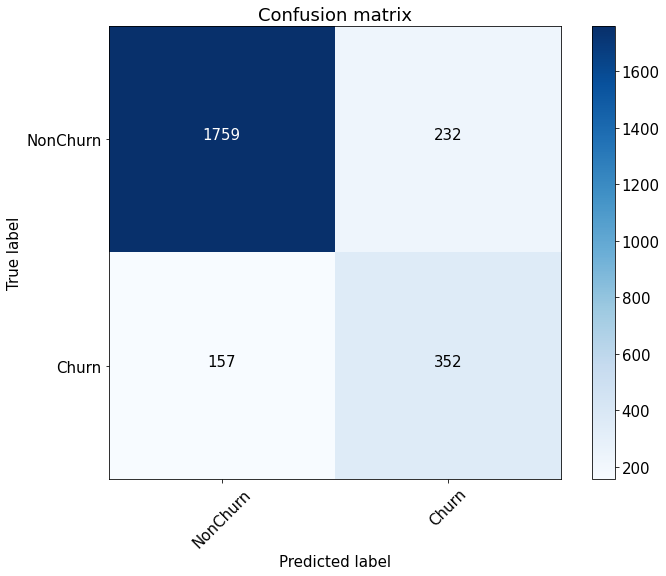

In [39]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

## 3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

Экономическую эффективность придлагаю считать следующим образом:
<br>   **ЭкЭф** = 
<br>        TP * 2 (получили от них 2р) + 
<br>        FN * 2 - FN (потому что мы получили от них 2р, но потратили на них 1р)) +  
       FP * 2 - FP (потому что мы неверно классифицировав их как уходящих постарити на низ 1р.) +
<br>        (- TN * 2) (потому что мы ошиблись, посчитав что они станутся, а они ушли со своми деньгами)

По данным п.2 Экономическая эффективность для наших моделей:

**RandomForest** = 1832 * 2 + 314 + 159 - 195 * 2 = `3 747`

**LogisticRegression** = 1655 * 2 + 288 + 336 - 221 * 2 = `3 492` - ***Худший показатель***

**CatBoost** = 1826 * 2 + 321 + 165 - 188 * 2 = `3 788` - **!!!Лучший показатель!!!**

**XGBoost** = 1793 * 2 + 321 + 198 - 188 * 2 = `3 729`

**GBoosting** = 1863 * 2 + 303 + 128 - 206 * 2 = `3 745`

## 4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

In [40]:
from catboost import CatBoostClassifier

In [41]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state=42)),
])

In [42]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'features', 'classifier', 'features__n_jobs', 'features__transformer_list', 'features__transformer_weights', 'features__verbose', 'features__Geography', 'features__Gender', 'features__Tenure', 'features__HasCrCard', 'features__IsActiveMember', 'features__CreditScore', 'features__Age', 'features__Balance', 'features__NumOfProducts', 'features__EstimatedSalary', 'features__Geography__memory', 'features__Geography__steps', 'features__Geography__verbose', 'features__Geography__selector', 'features__Geography__ohe', 'features__Geography__selector__column', 'features__Geography__ohe__key', 'features__Gender__memory', 'features__Gender__steps', 'features__Gender__verbose', 'features__Gender__selector', 'features__Gender__ohe', 'features__Gender__selector__column', 'features__Gender__ohe__key', 'features__Tenure__memory', 'features__Tenure__steps', 'features__Tenure__verbose', 'features__Tenure__selector', 'features__Tenure__ohe', 'features__Tenure__sel

In [43]:
from sklearn.model_selection import GridSearchCV

# params={'features__transformer_weights':[1, 2],
#         'classifier__min_samples_leaf':[1, 2, 3],
#         'classifier__max_depth':[None]
#         }

params = {
#     "classifier__loss":["deviance"],
#     "classifier__learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
#     "classifier__min_samples_split": np.linspace(0.1, 0.5, 12),
#     "classifier__min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "classifier__max_depth":[3, 5, 8],
#     "classifier__max_features":["log2","sqrt"],
#     "classifier__criterion": ["friedman_mse",  "mae"],
#     "classifier__subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "classifier__n_estimators":[5, 10]
    }


In [44]:
grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)

search.best_params_

{'classifier__max_depth': 8, 'classifier__n_estimators': 10}

In [45]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(max_depth = 8, n_estimators = 10, random_state=42)),
])
pipeline.fit(X_train, y_train)

preds = pipeline.predict_proba(X_test)[:, 1]

Best Threshold=0.324302, F-Score=0.629, Precision=0.650, Recall=0.609
Confusion matrix, without normalization
[[1824  167]
 [ 200  309]]


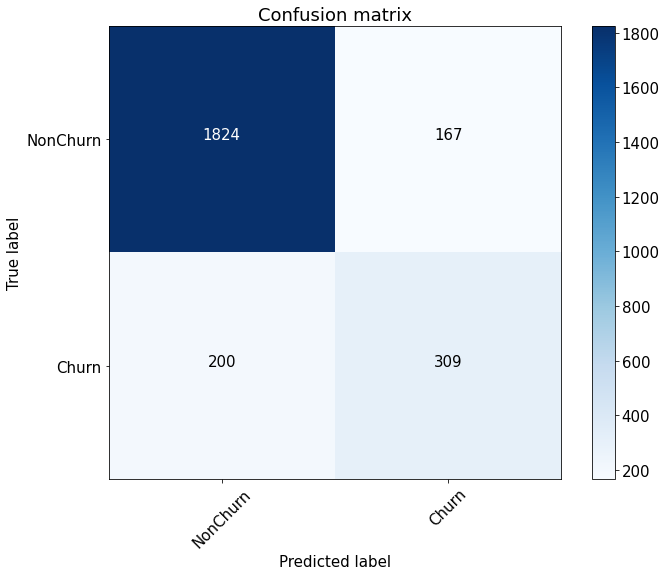

In [46]:

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

## 5. (опционально) Еще раз провести оценку экономической эффективности

#### Экономическая Эфективность после GreedSearch = 1863 * 2 + 303 + 128 - 206 * 2 = `3 745`